### Solved by: Razan Aljuhani , Alaa Alharbi , Wejdan Alzahrani , Lena Baeshen - Section: BAR


# **Recommendation Systems: Movie Recommendations**
---------------
## **Context**
---------------

Online streaming platforms like Netflix have plenty of movies in their repositories and if we can build a recommendation system to recommend relevant movies to users based on their historical interactions, this would improve customer satisfaction and hence improve revenue. The techniques that we will learn here will not only be limited to movies, it can be any item for which you want to build a recommendation system. 

-----------------
## **Objective**
-----------------

In this project we will be building various recommendation systems: 
- Popularity based recommendation system
- User-Based Collaborative filtering


based on the **ratings** dataset

-----------------
## **Dataset**
-----------------

The **ratings** dataset contains the following attributes: 
- userId
- movieId
- rating
- timestamp

### **Importing Libraries**

In [1]:
# installing surprise library, only do it for first time
!pip install surprise

In [45]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from surprise import accuracy

# class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# class for loading datasets
from surprise.dataset import Dataset

# for model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic



### **Loading the data**

In [46]:
rating = pd.read_csv('ratings.csv')

### Display information of the data

In [47]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


### 1) We don't need timestamp for our analysis. Hence, drop this column.

In [48]:
rating=rating.drop(['timestamp'],axis=1)

### Exploring the dataset.
### 2) Print head of the dataset.

In [49]:
rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


### 3) Plot the distribution of rating column.


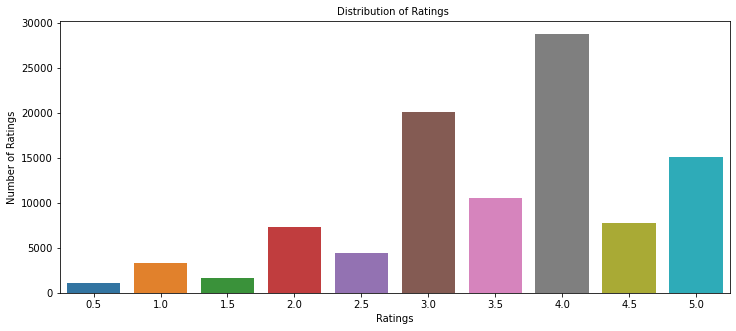

In [50]:
plt.figure(figsize = (12, 5))
ax = sns.countplot(x="rating", data =rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

### 4) Find number of unique users.

In [51]:
rating['userId'].nunique()

671

### 5) Find number of unique movie.

In [52]:
rating['movieId'].nunique()

9066

### 6) Find the most reviewed movie in the dataset.

In [53]:
rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
48520       1
111913      1
1311        1
27922       1
2049        1
Name: movieId, Length: 9066, dtype: int64

### 7) Plot the rating for the most reviewed movie in the dataset.

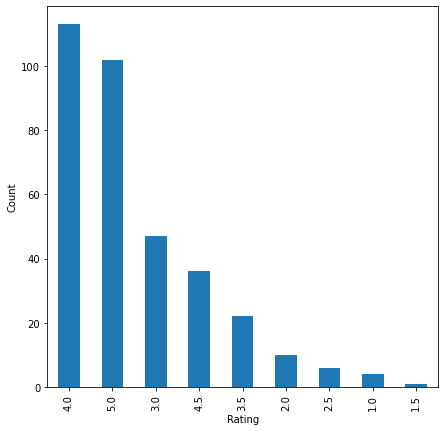

In [54]:
plt.figure(figsize=(7,7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()


###  8) Find the most interacted user in the dataset.

In [55]:
rating['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
221      20
444      20
484      20
35       20
485      20
Name: userId, Length: 671, dtype: int64

### **Model 1: Popularity Based Recommendation System**.


###  9) Take average of all the ratings provided to each movie and then rank them based on their average rating.

In [56]:
#Calculating average ratings
average_rating = rating.groupby('movieId').mean()['rating']

#Calculating the count of ratings
count_rating = rating.groupby('movieId').count()['rating']

#Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

### 10) Print the head of final rating.

In [57]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


###  11) Create a function to find the top n movies for a recommendation based on the average ratings of movies. Assume a minimum threshold number of interactions equal 70. 

In [58]:
def top_n_Movies(rating, n, min_rating_count=70):
    
    #Finding movies with minimum number of interactions
    recommendations = rating[rating['rating_count'] > min_rating_count]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

###  12) Recommend top 10 movies.

In [59]:
list(top_n_Movies(final_rating, 10 ))

[858, 318, 1221, 50, 1252, 904, 1203, 527, 908, 1193]

###  13) Recommend top 3 movies with 150 minimum interactions.

In [60]:
list(top_n_Movies(final_rating, 3 , 150 ))

[858, 318, 50]

### Model 2: User based Collaborative Filtering Recommendation System.

### 14) Make the dataset into surprise dataset and splitting it into train set 80% and test set 20%.

In [61]:
df=rating
df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [62]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(1, 5))

# loading the rating dataset
rating = Dataset.load_from_df(df[['userId', 'movieId', 'rating']], reader)

# splitting the data into train and test dataset
trainset, testset = train_test_split(rating, test_size=0.2, random_state=42)

### 15) Build similarity based recommendation system using cosine similarity and KNN.

In [63]:
sim_options = {'name': 'cosine',
               'user_based': True}

algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset, and predict ratings for the testset
algo_knn_user.fit(trainset)
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9916


0.9915759850028363

###  16) What is the Predicted  rating for an user with userId =4 and for movieId= 10 ?Supose user's review for this movie is 4.

In [64]:
algo_knn_user.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

###  17) What is the predicted  rating for an user with userId =4 and for movieId= 3 ? Supose user hasn't a review for this movie.

In [65]:
algo_knn_user.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

### 18) Perform hyperparameter tuning for the baseline user based collaborative filtering recommendation system and find the RMSE for tuned user based collaborative filtering recommendation system.

In [66]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, cv=3, n_jobs=-1)

# fitting the data
gs.fit(rating)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9661418760005636
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


### 19) Build final model by using tuned values of the hyperparameters which we received by using grid search cross validation.

In [67]:
# using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'msd',
               'user_based': True}

# creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options, k=20, min_k=3,Verbose=False)

# training the algorithm on the trainset
similarity_algo_optimized.fit(trainset)

# predicting ratings for the testset
predictions = similarity_algo_optimized.test(testset)

# computing RMSE on testset
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9571


0.9571445417153293

###  20) What is the predicted  rating for an user with userId =4 and for movieId= 10 ? Supose user's review for this movie is 4.

In [68]:
similarity_algo_optimized.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.74   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.740028692988536, details={'actual_k': 20, 'was_impossible': False})

###  21) What is the predicted  rating for an user with userId =4 and for movieId= 3 ? Supose user hasn't a review for this movie.

In [69]:
similarity_algo_optimized.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.72   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.7228745701935386, details={'actual_k': 20, 'was_impossible': False})

### 22) Find three similar users to userID =4.

In [70]:
similarity_algo_optimized.get_neighbors(4, k=3)

[665, 417, 647]

###  23) Implement the recommendation algorithm based on optimized KNNBasic model

In [71]:
def get_recommendations(rating, user_id, top_n, algo):
    
    # creating an empty list to store the recommended movies id
    recommendations = []

    # creating an user item interactions matrix 
    user_item_interactions_matrix = rating.pivot(index='userId', columns='movieId', values='rating')
    
    # extracting those movies ids which the user_id has not interacted yet
    non_interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
   
    # looping through each of the movies id which user_id has not interacted yet
    for movieId in non_interacted_items:
        
        # predicting the ratings for those non interacted movies ids by this user
        est = algo.predict(user_id, movieId).est
        
        # appending the predicted ratings
        recommendations.append((movieId, est))
      
    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)
    
    return recommendations[:top_n] # returing top n highest predicted rating items for this user

In [72]:
df=df.drop_duplicates()

###  24) Predicted top 5 movies for userId=4 with similarity based recommendation system

In [73]:
recommendations = get_recommendations(df, 4, 5, similarity_algo_optimized)

In [74]:
recommendations

[(309, 5),
 (3038, 5),
 (6273, 4.928202652354184),
 (98491, 4.863224466679252),
 (2721, 4.845513973527148)]